# Project 1: Digit Classification with KNN and Naive Bayes

In this project, different image recognition systems were implemented for classifying digits from the MNIST dataset. 

In [6]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [7]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data, and partition into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which is used in all the experiments below, unless otherwise noted.

In [8]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply 
# this permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

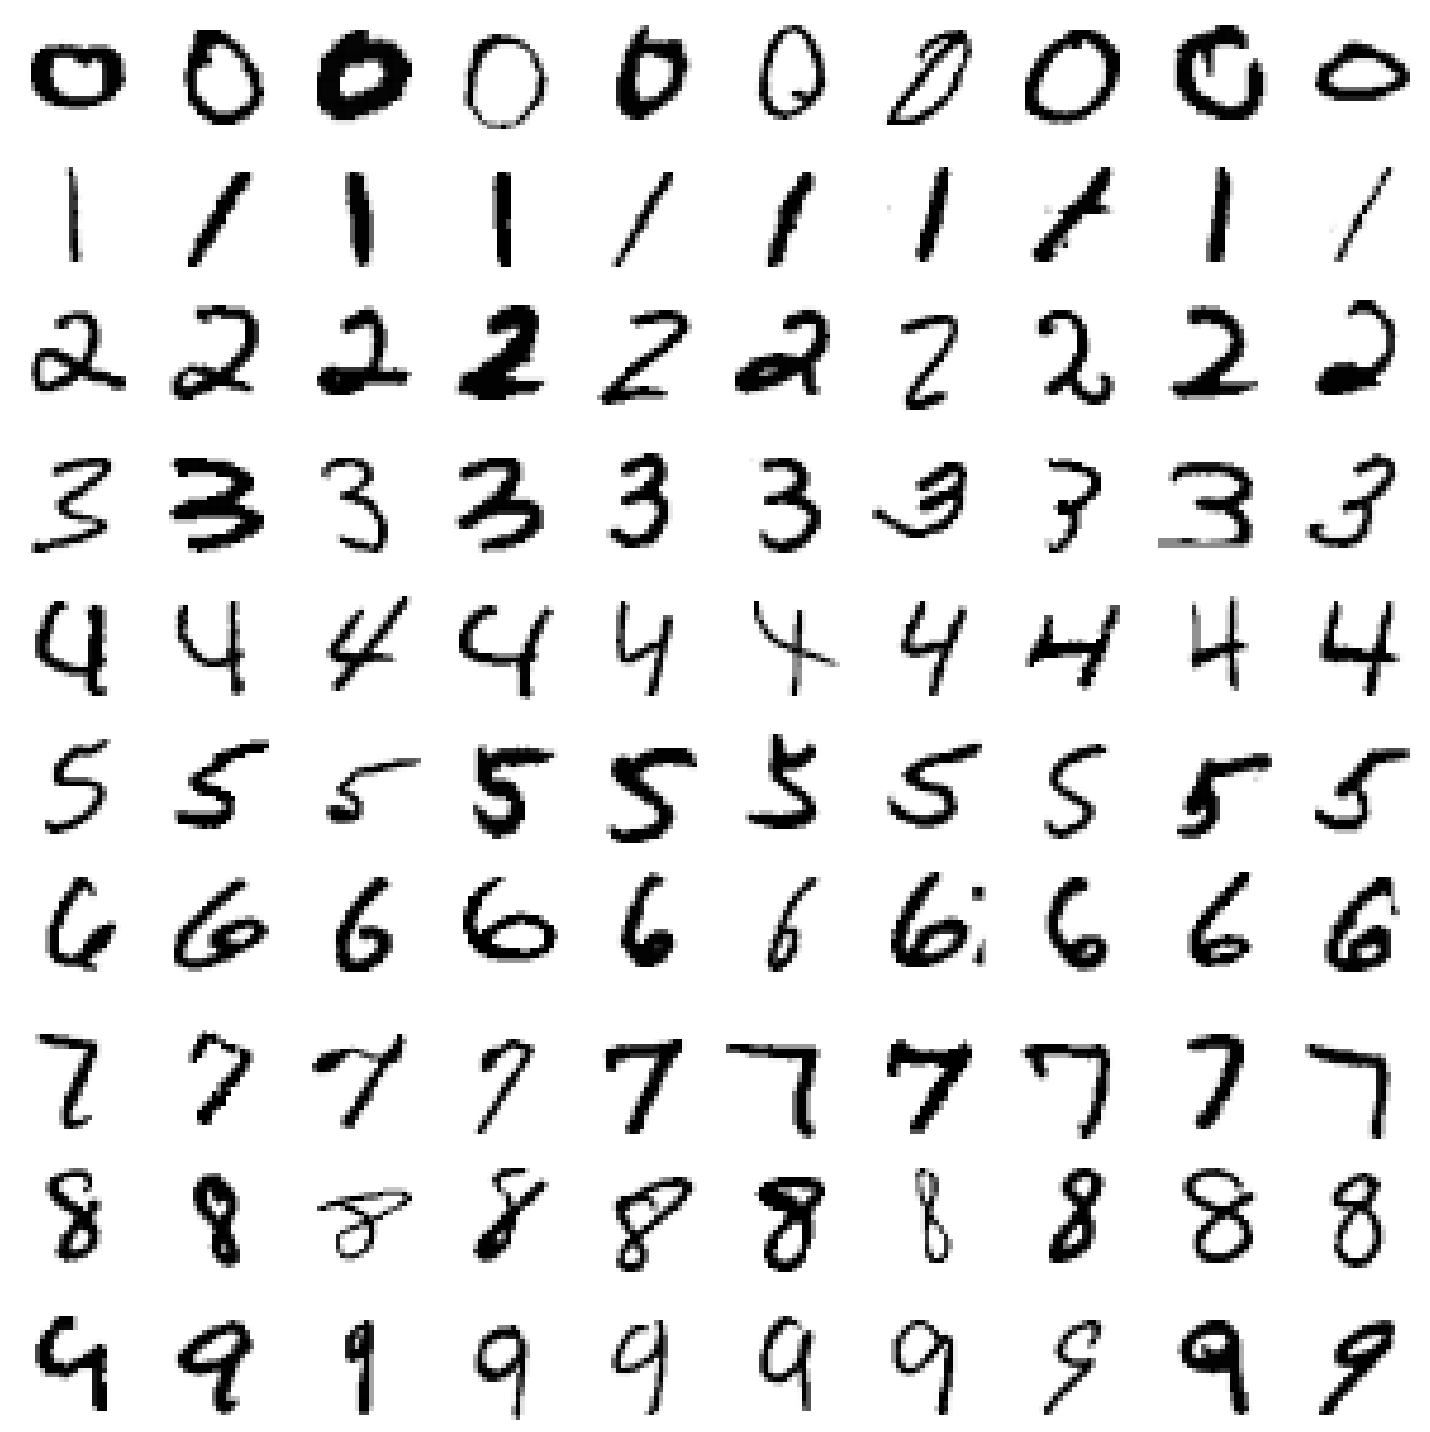

In [9]:
def create_grid(data, labels, digits=range(0,10), num_examples=10, figsize=(20,20), axes='off'):
    
    '''
    Creates a grid that visualizes a specified number of examples of
    each digit specified in the digits array. Each row in the grid contains
    the number of examples and each column is the range of digits in the
    digits array in descending order. By default, the digits are 0-9 and
    the number of examples is set to 10.
    
    Parameters
    ----------
    data (ndarray):
        An ndarray containing all examples and pixels within the data set.
    labels (ndarray):
        An ndarray containing the list of labels for the examples.
    digits (int[]):
        The digits that should be outputted in the grid (default=0-9).
    num_examples (int):
        The number of examples that should be printed per digit (default=10).
    figsize (int()):
        The size of the grid (passed into Matplotlib).
    axes (str):
        Turns the axes 'on' or 'off' (passed into Matplotlib).
        
    Returns
    -------
    None
    '''
    
    # Create the grid of subplots
    fig, ax = plt.subplots(len(digits), num_examples, figsize=figsize)
    
    # Create a counter of examples for each digit and a set that breaks the loop 
    # when all digits have been added to it
    counter_list = [0] * len(digits)
    break_set = set()
    
    # Loop through the data and labels and plot the appropriate digits until the 
    # number of examples has been reached for each digit
    for digit, label in zip(data, labels):
        
        label = int(label)
        
        # Skip the label if it is not one of the specified digits
        if label not in digits:
            continue
        
        else:
            if counter_list[digits.index(label)] < num_examples:
                grid = digit.reshape((28,28))
                
                # If there is only one digit specified, the subplots are in a 1-dimensional array
                if len(digits) == 1:
                    plot_digit(grid, ax[counter_list[digits.index(label)]], axes=axes)
                
                # Else, the subplots are in a 2-dimensional array
                else:
                    plot_digit(grid, ax[digits.index(label)][counter_list[digits.index(label)]], axes=axes)
                    
                counter_list[digits.index(label)] += 1

            elif counter_list[digits.index(label)] == num_examples:
                break_set.add(label)

            if len(break_set) == len(digits):
                break
    
    # Show the final grid
    fig.tight_layout()
    plt.show()    

def plot_digit(digit, ax, axes):
    
    '''
    Renders/plots the digit matrix on top of a specified ax.
    
    Parameters
    ----------
    digit (ndarray):
        The pixels of the digit to be plotted
    ax (Axes):
        The Axes object to be plotted on.
    axes (str):
        Turns the axes 'on' or 'off' (passed into Matplotlib).
        
    Returns
    -------
    None
    '''
    
    # Plot the digit matrix and turn off the axis labels
    ax.imshow(digit, cmap ='Greys', vmin = 0, vmax = 1) 
    ax.axis(axes)

create_grid(dev_data, dev_labels)

### Part 2:

Produce k-Nearest Neighbors models with k $\in$ [1,3,5,7,9].  Evaluate and show the accuracy of each model. For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label. Which digit is the most difficult for the 1-Nearest Neighbor model to recognize?

In [10]:

def KNN_model_predict(k, train_data, train_labels, eval_data):
    
    '''
    Creates a k-Nearest-Neighbors model based on some input k, which is then
    fit to some training data set and used to predict some evaluation set, 
    the results of which are then returned as output.
    
    Parameters
    ----------
    k (int):
        The number of nearest neighbors to use within the model.
    train_data (ndarray):
        An ndarray containing all examples and pixels within the train data set.
    train_labels (ndarray):
        An ndarray containing the list of labels for the trainig examples.
    eval_data (ndarray):
        An ndarray containing all examples and pixels within the evaluation data set.
        
    Returns
    -------
    Returns the result of the predictions for the evaluation data.
    '''
    
    model_KNN = KNeighborsClassifier(k)
    model_KNN.fit(train_data, train_labels)
    return model_KNN.predict(eval_data)

def KNN_prediction_scores(k_values, train_data, train_labels, eval_data, eval_labels):
    
    '''
    Calculates and displays the prediction accuracy scores for a range of k-Nearest-Neighbors 
    models with varying k values that are all trained and evaluated based on an input training
    data set and evaluation data set respectively.
    
    Parameters
    ----------
    k (int):
        The number of nearest neighbors to use within the model.
    train_data (ndarray):
        An ndarray containing all examples and pixels within the train data set.
    train_labels (ndarray):
        An ndarray containing the list of labels for the trainig examples.
    eval_data (ndarray):
        An ndarray containing all examples and pixels within the evaluation data set.
    eval_labels (ndarray):
        An ndarray containing the list of labels for the evaluation data set.
        
    Returns
    -------
    None
    '''
    
    # For every value of k, calculate and print the prediction accuracy results
    for k in k_values:
        
        print(f"K = {k}:")
        predicts = KNN_model_predict(k, train_data, train_labels, eval_data)
        
        # If model is 1NN, print the whole classification report
        if k == 1:
            print(classification_report(eval_labels, predicts))

        # Else for k > 1, only print the overall accuracy score
        else:
            
            print("Accuracy score -", classification_report(eval_labels, predicts, output_dict=True)['accuracy'])
            print()

            
# List of k values to be used in the models            
k_values = [1, 3, 5, 7, 9]

# Return the different metrics
KNN_prediction_scores(k_values, mini_train_data, mini_train_labels, dev_data, dev_labels) 
 

K = 1:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

K = 3:
Accuracy score - 0.876

K = 5:
Accuracy score - 0.882

K = 7:
Accuracy score - 0.877

K = 9:
Accuracy score - 0.875



**ANSWER:**

In terms of precision, the 1-Nearest Neighbor model has the most difficult time recognizing the digit 9, where precision is the accuracy of positive predictions. However, there are two other metrics to determine accuracy of predictions, which are recall and f1-score. For recall, the most diffcult digit to recognize was 8, which means that the model had the most difficult time correctly identified the positives for it. Finally, for the f1-score, the model again had the most difficult time predicted the digit 8, where the f1-score is the harmonious mean (a mean measure used for rates) of precision and recall. 

Thus, overall it would be fair to say that the model had the most difficult time recognizing the digit 8.

### Create a custom made Nearest Neighbors object using euclidean distance as the distance metric

Define the euclidean distance function and show a histogram of the distribution of euclidean distances.

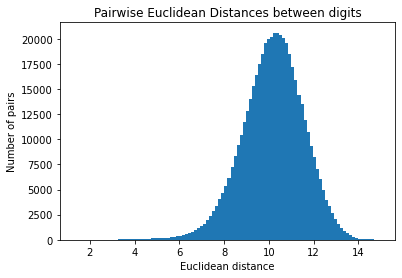

In [11]:
# Use the np.linalg.norm function to calculate the Ln Norm (default parameter of 2 = Euclidean distance)
def EuclideanDistance(v1, v2):
    
    '''
    Calculates the Euclidean distance between two vectors using the np.linalg.norm function
    
    Parameters
    ----------
    v1 (ndarray):
        A single vector ndarray.
    v2 (ndarray):
        A single vector ndarray.

    Returns
    -------
    The euclidean distance.
    '''
    
    return np.linalg.norm(v1 - v2)

# Compute all pairwise distances in the training data and store it in the list to plot on a histogram
dists = []
for i in range(len(mini_train_data) - 1):
    for j in range(i + 1, len(mini_train_data)):
        dist = EuclideanDistance(mini_train_data[i], mini_train_data[j])
        dists.append(dist)

# Plot the histogram distribution of the euclidean distances
plt.hist(dists,100)
plt.title("Pairwise Euclidean Distances between digits")
plt.ylabel("Number of pairs")
plt.xlabel("Euclidean distance")
pass

Create an implementation of a NearestNeighbors class from scratch and run predictions on it.

In [12]:
# Create the 1-NN class 

class NearestNeighbors:
    
    '''
    A custom class implementation of a 1-Nearest-Neighbors model.

    Attributes
    ----------
    metric (function):
        A function that computes the distance metric used to calculate the nearest neighbors.
    train_data (ndarray):
        An ndarray containing all examples and pixels within the train data set.
    train_labels (ndarray):
        An ndarray containing the list of labels for the trainig examples.
    '''
    
    # Initialize an instance of the class.
    def __init__(self, metric=EuclideanDistance):
        
        '''
        Constructs the NearestNeighbors object.

        Parameters
        ----------
        metric (function):
            A function that computes the distance metric used to calculate the nearest neighbors.
            Defaults to Euclidean Distance.

        Returns
        -------
        None
        '''
            
        self.metric = metric
        self.train_data = None
        self.train_labels = None
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        
        '''
        Fits the nearest neighbor model using the training data.

        Parameters
        ----------
        train_data (ndarray):
            An ndarray containing all examples and pixels within the train data set.
        train_labels (ndarray):
            An ndarray containing the list of labels for the trainig examples.

        Returns
        -------
        None
        '''
            
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        
        '''
        Makes class predictions on the test data. Calls the private _predict_item method.

        Parameters
        ----------
        test_data (ndarray):
            An ndarray containing all examples and pixels within the test data set.

        Returns
        -------
        results (int []):
            A list containing the prediction result for each example within the test data set.
        '''
            
        results = []
        
        for item in test_data:
            results.append(self._predict_item(item))
            
        return results
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        
        '''
        A private method to make a prediction on a single example.

        Parameters
        ----------
        item (ndarray):
            An ndarray containing all the pixels values of the example.

        Returns
        -------
        best_label (int):
            The class prediction result for the example.
        '''
        
        # Initialize the best distance at a large value and the best label at None
        best_dist, best_label = 1.0e10, None
        
        # For each example within the train data, calculate the distance metric
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            
            # If a smaller distance is found, update the best distance and label with that neighbor
            if dist < best_dist:
                best_label = self.train_labels[i]
                best_dist = dist
                
        return best_label

In [13]:
# Create the NearestNeighbors object
clf = NearestNeighbors()

# Store the train data in the NearestNeighbors object
clf.fit(mini_train_data, mini_train_labels)

#  Predict the label for each data point in the test data based on the nearest neighbor from the train data
dev_preds = clf.predict(dev_data)
print(classification_report(dev_labels, dev_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes. Evaluate and show the performance of each model. Additionally, show the time needed to measure the performance of each model.

In [14]:

def KNN_by_size(train_sizes, k, train_data, train_labels, eval_data, eval_labels):
    
    '''
    Uses a K-Nearest-Neighbor model to make predictions based on a range of training
    data set sizes. Displays the size of the training data set used, the prediction
    accuracy score of the model on the evaluation data set, and the time needed for the 
    model to make the predictions. Returns the list of times and accuracies for each 
    training set size.
    
    Parameters
    ----------
    train_sizes (int[]):
        A list of training data set sizes to train the KNN model on.
    k (int):
        The number of nearest neighbors to use within the model.
    train_data (ndarray):
        An ndarray containing all examples and pixels within the train data set.
    train_labels (ndarray):
        An ndarray containing the list of labels for the trainig examples.
    eval_data (ndarray):
        An ndarray containing all examples and pixels within the evaluation data set.
    eval_labels (ndarray):
        An ndarray containing the list of labels for the evaluation data set.
        
    Returns
    -------
    times (float[]):
        The list of elapsed times taken to make predictions corresponding to the list of training set sizes.
    accuracies (int[]):
        The list of prediction accuracy scores corresponding to the list of training set sizes. 
    '''
    
    # Initialize empty lists to store the accuracy and elapsed time for each training set size
    accuracies = []
    times = []

    # For each size in the range of training data set sizes, train a KNN model and calculate
    # the prediction accuracy on the evaluation data set
    for size in train_sizes:

        # Capture the start time
        start_secs = time.time()

        predicts = KNN_model_predict(k, train_data[:size], train_labels[:size], eval_data)
        print(f"Size = {size}:")

        acc = classification_report(eval_labels, predicts, output_dict=True)['accuracy']
        accuracies.append(acc)
        print("Accuracy score -", acc)

        # Capture the end time
        finish_secs = time.time()

        # Calculate the elapsed time
        elapsed = finish_secs - start_secs
        times.append(elapsed)
        print(f"Time elapsed (seconds): {elapsed:.2f}\n")
        
    return times, accuracies

# Create a range of train data set sizes to train the model on
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]

# Set the number of nearest neighnors
k = 1

# Show the performance and time elapsed for each training set size
times, accuracies = KNN_by_size(train_sizes, k, train_data, train_labels, dev_data, dev_labels)


Size = 100:
Accuracy score - 0.702
Time elapsed (seconds): 0.15

Size = 200:
Accuracy score - 0.791
Time elapsed (seconds): 0.26

Size = 400:
Accuracy score - 0.811
Time elapsed (seconds): 0.48

Size = 800:
Accuracy score - 0.866
Time elapsed (seconds): 0.98

Size = 1600:
Accuracy score - 0.905
Time elapsed (seconds): 1.94

Size = 3200:
Accuracy score - 0.927
Time elapsed (seconds): 3.83

Size = 6400:
Accuracy score - 0.939
Time elapsed (seconds): 7.71

Size = 12800:
Accuracy score - 0.952
Time elapsed (seconds): 15.74

Size = 25600:
Accuracy score - 0.963
Time elapsed (seconds): 32.49



### Use the custom made Nearest Neighbors object to run predictions on the range of training set sizes

In [15]:
def custom_1NN_by_size(train_sizes, train_data, train_labels, eval_data, eval_labels):
    
    '''
    Uses a custom 1-Nearest-Neighbor implementation to make predictions based on a range of 
    training data set sizes. Displays the size of the training data set used, the prediction
    accuracy score of the model on the evaluation data set, and the time needed for the model 
    to make the predictions. Returns the list of times and accuracies for each training set size.
    
    Parameters
    ----------
    train_sizes (int[]):
        A list of training data set sizes to train the KNN model on.
    train_data (ndarray):
        An ndarray containing all examples and pixels within the train data set.
    train_labels (ndarray):
        An ndarray containing the list of labels for the trainig examples.
    eval_data (ndarray):
        An ndarray containing all examples and pixels within the evaluation data set.
    eval_labels (ndarray):
        An ndarray containing the list of labels for the evaluation data set.
        
    Returns
    -------
    times (float[]):
        The list of elapsed times taken to make predictions corresponding to the list of training set sizes.
    accuracies (int[]):
        The list of prediction accuracy scores corresponding to the list of training set sizes. 
    '''
    
    # Initialize empty lists to store the accuracy and elapsed time for each training set size
    accuracies = []
    times = []

    # For each size in the range of training data set sizes, train a KNN model and calculate
    # the prediction accuracy on the evaluation data set
    for size in train_sizes:

        # Capture the start time
        start_secs = time.time()
        
        # Create the NearestNeighbors object
        clf = NearestNeighbors()

        # Store the train data in the NearestNeighbors object
        clf.fit(train_data[:size], train_labels[:size])

        #  Predict the label for each test data point based on the nearest neighbor from the train data
        predicts = clf.predict(eval_data)
        print(f"Size = {size}:")

        acc = classification_report(eval_labels, predicts, output_dict=True)['accuracy']
        accuracies.append(acc)
        print("Accuracy score -", acc)

        # Capture the end time
        finish_secs = time.time()

        # Calculate the elapsed time
        elapsed = finish_secs - start_secs
        times.append(elapsed)
        print(f"Time elapsed (seconds): {elapsed:.2f}\n")
        
    return times, accuracies

custom_1NN_by_size(train_sizes, train_data, train_labels, dev_data, dev_labels)

Size = 100:
Accuracy score - 0.702
Time elapsed (seconds): 0.59

Size = 200:
Accuracy score - 0.791
Time elapsed (seconds): 1.16

Size = 400:
Accuracy score - 0.811
Time elapsed (seconds): 2.27

Size = 800:
Accuracy score - 0.866
Time elapsed (seconds): 4.62

Size = 1600:
Accuracy score - 0.905
Time elapsed (seconds): 9.28

Size = 3200:
Accuracy score - 0.927
Time elapsed (seconds): 18.39

Size = 6400:
Accuracy score - 0.939
Time elapsed (seconds): 36.69

Size = 12800:
Accuracy score - 0.952
Time elapsed (seconds): 72.65

Size = 25600:
Accuracy score - 0.963
Time elapsed (seconds): 144.88



([0.5940308570861816,
  1.1586740016937256,
  2.271637201309204,
  4.62015700340271,
  9.275447130203247,
  18.39212417602539,
  36.68818020820618,
  72.65079116821289,
  144.88484406471252],
 [0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.963])

Plot the train data set size vs the prediction accuracy, with the markers color-labeled with the time elapsed.

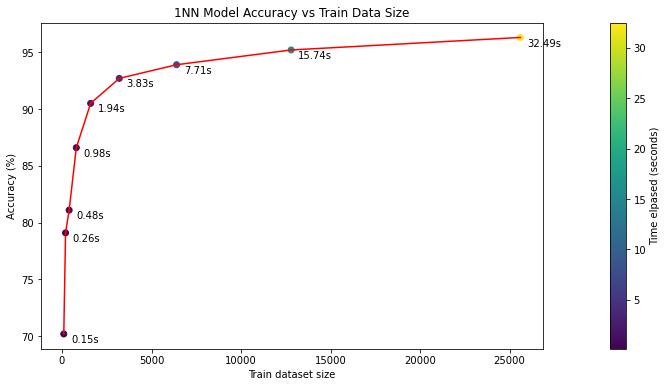

In [16]:
# Change the accuracies to 0-100%
accuracies_pct = np.multiply(accuracies, 100)

# Create the figure and the scatter plot with color scheme set to the times
plt.figure(figsize=(12,6))
plt.scatter(train_sizes, accuracies_pct, c=times)
plt.colorbar(pad=0.1).set_label("Time elpased (seconds)")

# For each point on the scatter plot, add a text annotation with the time
for t,a,size in zip(times, accuracies_pct, train_sizes):
    plt.annotate(f"{t:.2f}s", (size, a), xytext=(size+400, a-0.75))
    
# Plot the line plot of the train size vs accuracy
plt.plot(train_sizes, accuracies_pct, '-r')
plt.title("1NN Model Accuracy vs Train Data Size")
plt.xlabel("Train dataset size")
plt.ylabel("Accuracy (%)")

plt.show()

### Part 4:

Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.

Linear Regression Model, R²: 0.4177
Model accuracy prediction given training set size 60000 -> 123.62% accuracy
Model accuracy prediction given training set size 120000 -> 163.74% accuracy
Model accuracy prediction given training set size 1000000 -> 752.25% accuracy


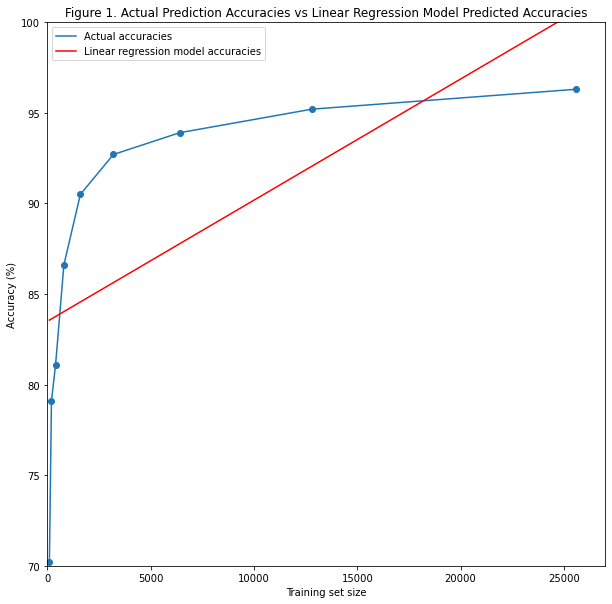

In [17]:

def LR_predict(train_x, train_y, to_predict):

    '''
    Uses a linear regression model to predict the accuracy of a 1NN model
    given an input training set size by training the regression model on a set 
    of train sizes and accuracies outputted from the 1NN model. Calculates and 
    displays the R^2 value of the model as well as the predicted accuracies for
    a some training set sizes. Returns the training sizes and the predicted accuracies 
    
    Parameters
    ----------
    train_x (ndarray):
        An ndarray containing all examples within the train data set.
    train_y (ndarray):
        An ndarray containing the list of labels for the training examples.
    to_predict (ndarray):
        An ndarray containing the examples to be predicted
        
    Returns
    -------
    predict_x (ndarray):
        The inputs to be used in the predictions from the linear regression model.
    predictions (ndarray):
        The predicted values of the linear regression model. 
    '''

    # If either of the train_x or train_x sets are not np.arrays, convert and reshape them
    if type(train_x) != np.array:
        train_x = np.array(train_x).reshape(-1,1)

    if type(train_y) != np.array:
        train_y = np.array(train_y).reshape(-1,1) 
    
    # Fit the linear regression model and print the R^2 value
    reg = LinearRegression().fit(train_x, train_y)
    print(f"Linear Regression Model, R\u00b2: {reg.score(train_x, train_y):.4f}")
    
    # Stack the training set sizes and predict the respective accuracies 
    predict_x = np.vstack((train_x, to_predict))
    predictions = reg.predict(predict_x)

    # Print the linear regression model accuracy for the to_predict training set sizes
    for x, y in zip(to_predict, predictions[len(predictions)-3:]):
        if x < 100:
            x = np.exp(x)
        print(f"Model accuracy prediction given training set size {x[0]:.0f} -> {y[0]*100:.2f}% accuracy")
        
    return predict_x, predictions

# Store the training set sizes to be predicted in a np.array
predicts = np.array([[60000], [120000], [1000000]])

# Make the predictions
LR_train_sizes, LR_accuracies = LR_predict(train_sizes, accuracies, predicts)

# Change the actual accuracies to 0-100%
accuracies_pct = np.multiply(accuracies, 100)

# Plot the regression line and the actual 1NN accuracies scatter plot
plt.figure(figsize=(10,10))
plt.scatter(train_sizes, accuracies_pct)
plt.plot(train_sizes, accuracies_pct, label="Actual accuracies")
plt.plot(LR_train_sizes, np.multiply(LR_accuracies, 100), '-r', label = "Linear regression model accuracies")
plt.title("Figure 1. Actual Prediction Accuracies vs Linear Regression Model Predicted Accuracies")
plt.xlabel("Training set size")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.xlim(0, 27000)
plt.ylim(70,100)
plt.show()


Apply a logarithmic transformation to the predictor features and a transformation to the outcome that make the predictions more reasonable.  Show $R^2$ of the improved linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.

Linear Regression Model, R²: 0.9068
Model accuracy prediction given training set size 60000 -> 103.36% accuracy
Model accuracy prediction given training set size 120000 -> 106.43% accuracy
Model accuracy prediction given training set size 1000000 -> 115.83% accuracy


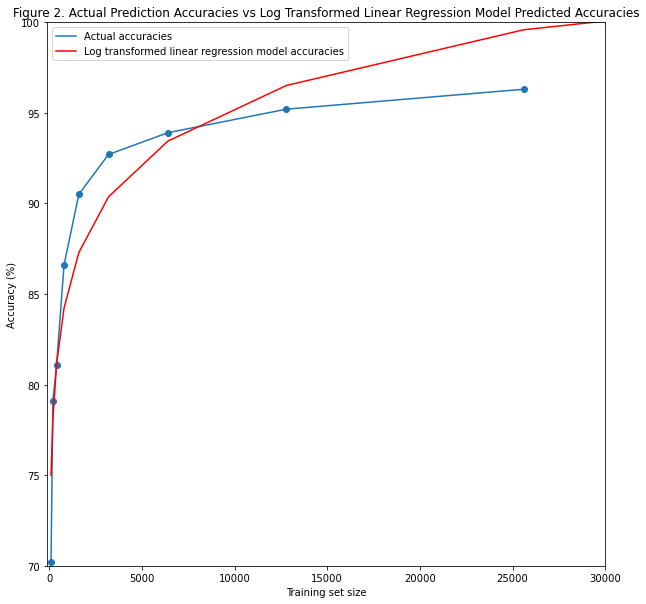

In [18]:
# Apply a natural log transform on both the train_sizes and the sizes to predicted
log_train_sizes = np.log(train_sizes)
log_predicts = np.log(predicts)

# Make the predictions
LR_log_train_sizes, LR_accuracies = LR_predict(log_train_sizes, accuracies, log_predicts)

# Plot the regression line of the log relationship and the log of the actual 1NN accuracies scatter plot
plt.figure(figsize=(10,10))
plt.scatter(train_sizes, accuracies_pct)
plt.plot(train_sizes, accuracies_pct, label="Actual accuracies")
plt.plot(LR_train_sizes, np.multiply(LR_accuracies, 100), '-r', label = "Log transformed linear regression model accuracies")

plt.title("Figure 2. Actual Prediction Accuracies vs Log Transformed Linear Regression Model Predicted Accuracies")
plt.xlabel("Training set size")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.ylim(70,100)
plt.xlim(-100,30000)
plt.show()


**ANSWER:**

The problem with using linear regression to predict the accuracy of a certain training set size in classifying the images in the MNIST dataset into the correct digits is due to the fact that the relationship between training set size and accuracy is not linear (as can be seen in Figure 1). In actuality, the relationship is better described as a logarithmic relationship, as can be seen in Figure 2 above. As the training set size increases, the  prediction accuracy does improve, but the rate of improvement decreases as the training set size continues to grow. 

### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Show the images of these most often confused digits.

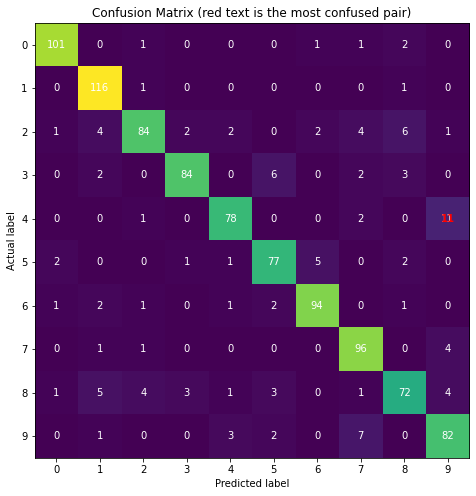

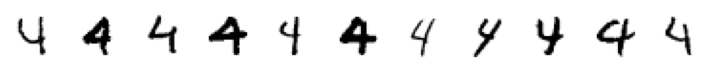

In [19]:
         
def plot_confusion_matrix(actual, predicted):
    
    '''
    Plots the confusion matrix of the actual labels vs the predicted labels 
    and marks the most confused pairing of actual vs predicted labels in red text.
    Returns the coordinates of the most confused pair.
    
    Parameters
    ----------
    actual (ndarray):
        The actual labels of the examples.
    predicted (ndarray):
        The predicted labels fo the examples
        
    Returns
    -------
    coord (int()):
        The coordinates on the confusion matrix of the most confused pair of digits.
    '''

    # Calculate the confusion matrix
    cm = confusion_matrix(actual, predicted)
    
    # Plot the confusion matrix 
    plt.figure(figsize=(8,8))
    plt.imshow(cm)
    
    plt.title("Confusion Matrix (red text is the most confused pair)")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    
    most = 0
    coord = (0,0)
    
    # Loop through the confusion matrix and annotate each confusion pair
    # while finding the value and the coordinates of the highest confusion pair
    for i in range(10):
        for j in range(10):
            
            if i != j:
                if cm[i,j] > most:
                    most = cm[i,j]
                    coord = i,j    
                    
            plt.text(j, i, cm[i,j], ha="center", va="center", color="w")
    
    # Annotate the highest confusion pair in red text
    plt.text(coord[1], coord[0], most, ha="center", va="center", color="r", fontweight="extra bold")
    
    return coord

def find_confused(actual, predicted, most_confused):

    '''
    Finds and returns the indices in the data set that holds the most confused digits.

    Parameters
    ----------
    actual (ndarray):
        The actual labels of the examples.
    predicted (ndarray):
        The predicted labels fo the examples.
    most_confused (int()):
        The coordinates on the confusion matrix of the most confused pair of digits.
        
    Returns
    -------
    confused_indices (int[]:
        The indices of all of the most confused digit examples within the data set.
    '''
    
    # Create a truth matrix where the actual labels do not equal the predicted labels
    compare = (actual != predicted)
    
    confused_indices = []
    
    # Loop through the values where actual != predicted and append the indices of
    # the most confused digits
    for i in range(0, len(compare)):
        if compare[i]:
            if  int(actual[i]) == most_confused[0] and int(predicted[i]) == most_confused[1]:
                confused_indices.append(i)
                
    return confused_indices 

# Predict the dev labels with a 1NN model
predicted = KNN_model_predict(1, mini_train_data, mini_train_labels, dev_data)

# Plot the confusion matrix and find the most confused pair
most_confused_pair = plot_confusion_matrix(dev_labels, predicted)

# Find the indices of actual digit of the most confused pair
confused = find_confused(dev_labels, predicted, most_confused_pair)
    
# Plot the most confused digits
create_grid(dev_data[np.array(confused)], dev_labels[np.array(confused)], digits=[most_confused_pair[0]], 
               num_examples = len(confused), figsize=(10,10))


**ANSWER:**

1-Nearest Neighbor model confuses the digit 4 as a 9 most often out of all digit pairs. 

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Pick a weight, then produce and evaluate four 1-Nearest Neighbor models by applying the blur filter in these ways:
- Do not use the filter
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracies of the four models evaluated as described. 

In [20]:

def guassian_function(x, y, sigma):

    '''
    Computes the weight of a coordinate using the two dimensional Gaussian 
    distribution function.
    
    Parameters
    ----------
    x (int):
        The x coordinate of the Gaussian distribution function.
    y (int):
        The x coordinate of the Gaussian distribution function.
    sigma (int):
        The weighting used to determine the Guassian distribution.
        
    Returns
    -------
    ans (int):
        The weight of the coordinate given the Guassian distribution function.
    '''
    
    sigma_sq = sigma**2
    x_sq = x**2
    y_sq = y**2
    
    ans = 1/(2 * np.pi * sigma_sq)
    ans *= np.exp(-(x_sq+y_sq)/(2*sigma_sq))
    
    return ans

def weighted_matrix(sigma, blur_radius=1):

    '''
    Creates a weighted matrix to use for blurring based on a weight value (sigma) 
    and blur radius, which is the number of adjacent coordinates to be used in the 
    weighted matrix. 
    
    Parameters
    ----------
    sigma (int):
        The weighting used to determine the Guassian distribution.
    blur_radius (int):
        The radius of the blur  based on neighboring pixels (for example, a blur radius of 1 
        will result in 8 neighboring coordinates, while a radius of 2 will result in 24 neighbors).
        Defaults to a radius of 1.
        
    Returns
    -------
    w_matrix (int):
        The weighted matrix to be applied for the blurring effect.
    '''
    
    # Find the edges and the dimensions of the matrix
    neg_edge = -1*blur_radius
    pos_edge = blur_radius+1
    dim = pos_edge - neg_edge
    
    # Initialize an empty matrix with appropriate size
    w_matrix = np.empty(shape=(dim,dim))
    w_sum = 0
    
    # Calculate the weight for each coordinate in the matrix based off it's distance 
    # from the central coordinate and the sigma value
    for i in range(neg_edge, pos_edge):
        for j in range(neg_edge, pos_edge):
            w_matrix[i+blur_radius][j+blur_radius] = guassian_function(i, j, sigma)
            w_sum += w_matrix[i+blur_radius][j+blur_radius]
    
    # Normalize the matrix by dividing by the weighted sum
    w_matrix = np.divide(w_matrix, w_sum)
            
    return w_matrix


def blur_data(data, w_matrix, blur_radius=1):
    
    '''
    Applies a blur filter to the input data using the weighted matrix. 
    The blur radius used should be equal to the radius applied when 
    creating the weighted matrix.
    
    Parameters
    ----------
    data (ndarray):
        The data that should be blurred using the weighted matrix.
    w_matrix (int):
        The weighted matrix to be applied for the blurring effect.
    blur_radius (int):
        The radius of the blur  based on neighboring pixels (for example, a blur radius of 1 
        will result in 8 neighboring coordinates, while a radius of 2 will result in 24 neighbors).
        Defaults to a radius of 1.
        
    Returns
    -------
    blurred_data (ndarray):
        The blurred data after the weighted matrix was applied.
    '''
    
    # Initialize blurred_data to be hold all the blurred samples
    blurred_data = np.empty_like(data)
        
    # Loop through each sample in the data and apply the blurring filter 
    for s,sample in enumerate(data):

        # Reshape the sample in pixel form and initiliaze a temporary data point
        sample = sample.reshape(28,28)
        blurred_sample = np.empty_like(sample, dtype=float)

        # Apply a padding of 0's to the edges of the sample to allow for blurring
        for i in range(0, blur_radius):

            zero_col = np.zeros((len(sample),1))
            sample = np.hstack((zero_col, sample, zero_col))

            zero_row = np.zeros(len(sample[0]))
            sample = np.vstack((zero_row, sample, zero_row))
            
        # For each coordinate in the sample, multiply itself and it's neighboring coordinates 
        # by the weighted matrix
        for y in range(blur_radius, len(sample) - blur_radius):
            for x in range(blur_radius, len(sample) - blur_radius):
                mini_array = sample[y-blur_radius:y+blur_radius+1,x-blur_radius:x+blur_radius+1]
                blurred_sample[y-blur_radius,x-blur_radius] = np.sum(mini_array*w_matrix)
         
        # Add the blurred sample to the blurred_data data set
        blurred_data[s] = blurred_sample.reshape((1,784))
        
    return blurred_data

# Set the hyperparameters (blur radius, sigma weight, and k values for nearest neighbors)
radius = 1
sigma = 1.2
k_values = [1]

# Create the weighted matrix
w_matrix = weighted_matrix(sigma, blur_radius=radius)

# Blur the train and dev datasets
mini_train_blur = blur_data(mini_train_data, w_matrix, blur_radius=radius)
dev_blur = blur_data(dev_data, w_matrix, blur_radius=radius)

# 1NN prediction with no filter
print("1-Nearest Neighbor model without a blur filter\n")
KNN_prediction_scores(k_values, mini_train_data, mini_train_labels, dev_data, dev_labels)

# 1NN prediction with blur filter on training data
print("1-Nearest Neighbor model with a blur filter on training data\n")
KNN_prediction_scores(k_values, mini_train_blur, mini_train_labels, dev_data, dev_labels)

# 1NN prediction with blur filter on the dev data
print("1-Nearest Neighbor model with a blur filter on evaluation data\n")
KNN_prediction_scores(k_values, mini_train_data, mini_train_labels, dev_blur, dev_labels)

# 1NN prediction with blur filter on both training and dev data
print("1-Nearest Neighbor model with a blur filter on both the training and evaluation data\n")
KNN_prediction_scores(k_values, mini_train_blur, mini_train_labels, dev_blur, dev_labels)


1-Nearest Neighbor model without a blur filter

K = 1:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

1-Nearest Neighbor model with a blur filter on training data

K = 1:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       106
        

Plot a 10x10 grid of the data after the blurred data is applied.

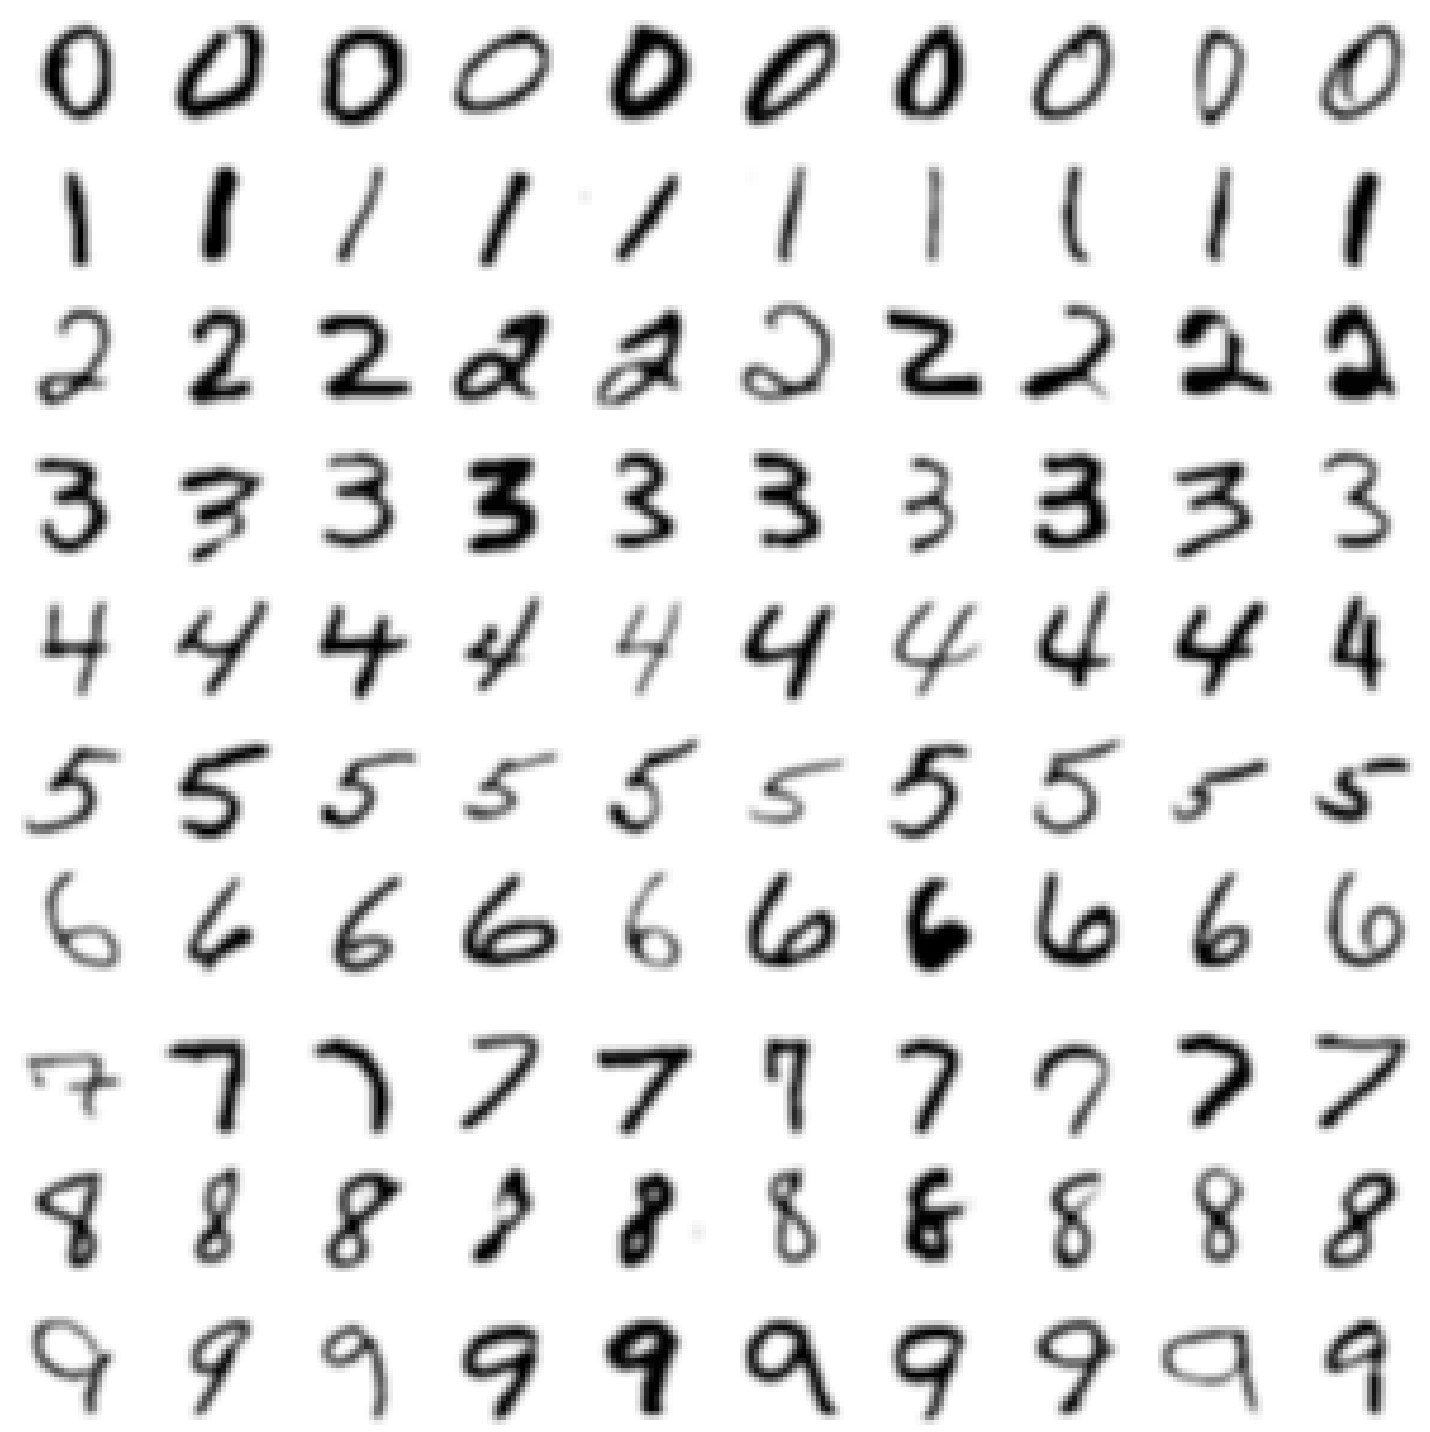

In [21]:
# Take a look at the blur effect on the data
create_grid(mini_train_blur, mini_train_labels)

### Part 7:

Produce two Naive Bayes models and evaluate their performances.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

In [22]:
def map_continuous(data, thresholds=[], right=False):
    
    '''
    A function that takes as input a set of continuous data and maps the features 
    into n discrete bins from 0 to n-1 based on the thresholds provided for each feature, 
    where n-1 is the number thresholds specified per feature. If the thresholds are 
    not provided, the function will binarize (0,1) the values by using the mean 
    of each feature as the threshold.
    
    Parameters
    ----------
    data (ndarray):
        The data to be mapped.
    thesholds (int[]):
        The thresholds that are used to determine the intervals for the mapping of the data into bins.
        Defaults as a single threshold equal to the mean of the data.
    right (bool):
        Determines whether the right-most bin interval includes the right bin edge.
        Defaults to False.
        
    Returns
    -------
    mapped_data (ndarray):
        The data mapped to the intervals based on the thresholds provided.
    thresholds (int[]):
        The thresholds that are used to determine the intervals for the mapping of the data into bins.
    '''
    
    # Calculate the threshold for each feature if it was not passed in as an argument
    if not thresholds:
        for i in range(data.shape[1]):
            thresholds.append([data[:,i].mean()])
    
    # Initialize a new feature array with the same shape as the original data.
    mapped_data = np.empty(data.shape)

    # Digitize each feature and map them to bins between 0 to number of thresholds
    for feature in range(data.shape[1]):
        mapped_data[:,feature] = np.digitize(data[:,feature], thresholds[feature], right=right)

    return mapped_data, thresholds

# Binarize the mini_train and dev datasets
bin_mini_train_data, bin_thresholds = map_continuous(mini_train_data, thresholds=[[0.1]]*784)
bin_dev_data, bin_thresholds = map_continuous(dev_data, thresholds=[[0.1]]*784)

# Ternarize the mini_train and dev datasets
tern_mini_train_data, thresholds = map_continuous(mini_train_data, thresholds=[[0.1,0.9]]*784)
tern_dev_data, thresholds = map_continuous(dev_data, thresholds=[[0.1,0.9]]*784)

Bernoulli NB accuracy score - 0.814
Multinomial NB accuracy score - 0.807


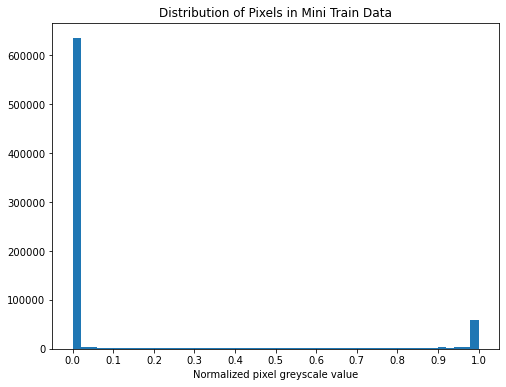

In [23]:
# Fit and predict the Bernoulli model
bernoulli = BernoulliNB(binarize=None)
bernoulli.fit(bin_mini_train_data, mini_train_labels)
bin_predicts = bernoulli.predict(bin_dev_data)

# Fit and predict the Multinomial model
multi = MultinomialNB()
multi.fit(tern_mini_train_data, mini_train_labels)
multi_predicts = multi.predict(tern_dev_data)

# Print the accuracy scores for each model
print("Bernoulli NB accuracy score -", classification_report(dev_labels, bin_predicts, output_dict=True)['accuracy'])
print("Multinomial NB accuracy score -", classification_report(dev_labels, multi_predicts, output_dict=True)['accuracy'])

# Plot the histogram of the normalized greyscale values of the mini_train_data
plt.figure(figsize=(8,6))
plt.hist(mini_train_data.ravel(), bins=50)
plt.title("Distribution of Pixels in Mini Train Data")
plt.xlabel("Normalized pixel greyscale value")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()


**ANSWER:**

The Multinomial Naive Bayes model does not improve the results of the accuracy score, and in fact reduces the accuracy score. 

Firstly, the Multinomial score is very similar to the Bernoulli score given that the majority of pixels have values at the extreme ends of the normalized scores (close to 0 or 1). This can be seen from the histogram above. As a result, creating a third class for grey between 0.1 and 0.9 does not account for very many of the pixels, and therefore should not affect the overall accuracy score very much.

The observed slight decrease in score is likely due to the fact that the Naive Bayes algorithm assumes that the features (in this case each pixel) are indepedent. Given this independence assumption, we assume that the probability of seeing a white pixel vs a grey pixel vs a black pixel is independent, even though these values will be dependent on the other pixels around them. Therefore, separating out a black pixel (0.1-1) in the binomial case into either a grey pixel (0.1-0.9) or black pixel (0.9-1) will lower the frequencies of each of these pixels occuring　(although very slightly). Thus, the multinomial model will have a more difficult time predicting the labels (or digits) for black given that it has less confidence to make the prediction.

### Third Multinomial model

Build a third model using a Multinomial Naive Bayes model with pixels mapped to 100 evenly spaced bins (0.01 to 1).  Use `MultinomialNB` to produce the model. 

In [24]:
# Use 100 evenly spaced thresholds on the mini_train and dev datasets
hun_mini_train_data, hun_thresholds = map_continuous(mini_train_data, thresholds=[[0.01*i for i in range(1,100)]]*784)
hun_dev_data, hun_thresholds = map_continuous(dev_data, thresholds=[[0.01*i for i in range(1,100)]]*784)

In [25]:
# Check multinomial using 100 discrete values for each feature
hun = MultinomialNB()
hun.fit(hun_mini_train_data, mini_train_labels)
hun_predicts = hun.predict(dev_data)
print("100 NB Accuracy score -", classification_report(dev_labels, hun_predicts, output_dict=True)['accuracy'])

100 NB Accuracy score - 0.815


In [26]:
# Print the reports for bernoulli, multinomial 3, and multinomial 100
print(classification_report(dev_labels, bin_predicts))
print(classification_report(dev_labels, multi_predicts))
print(classification_report(dev_labels, hun_predicts))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       106
           1       0.88      0.95      0.91       118
           2       0.81      0.72      0.76       106
           3       0.74      0.76      0.75        97
           4       0.76      0.85      0.80        92
           5       0.83      0.68      0.75        88
           6       0.87      0.88      0.88       102
           7       0.88      0.86      0.87       102
           8       0.65      0.72      0.68        94
           9       0.78      0.77      0.77        95

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       0.87      0.87      0.87       118
           2       0.79      0.73      0.75       106
           3       0.76 

### Part 8:

Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

In [27]:
# Binarize the mini_train and dev datasets with a thresold of 0
zero_mini_train_data, zero_thresholds = map_continuous(mini_train_data, thresholds=[[0]]*784, right=True)

# Set the alphas to be tested
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

# Initialize the GridSearchCV function with a Bernoulli NB classifier and the alpha
gridsearch = GridSearchCV(BernoulliNB(binarize=None), param_grid=alphas)
gridsearch.fit(zero_mini_train_data, mini_train_labels)

# Print the mean test score for each alpha value
scores = iter(gridsearch.cv_results_['mean_test_score'])
for alpha in gridsearch.cv_results_['param_alpha']: 
    print(f"Alpha value - {alpha}:".ljust(21), f"{next(scores):.3f}")


# Find the best alpha and score
alpha = gridsearch.best_params_['alpha']
print()
print("Best alpha:", alpha)
print("Score for best alpha:", gridsearch.best_score_)


Alpha value - 1e-10:  0.814
Alpha value - 0.0001: 0.819
Alpha value - 0.001:  0.825
Alpha value - 0.01:   0.822
Alpha value - 0.1:    0.818
Alpha value - 0.5:    0.813
Alpha value - 1.0:    0.809
Alpha value - 2.0:    0.805
Alpha value - 10.0:   0.783

Best alpha: 0.001
Score for best alpha: 0.825


**ANSWER:**

The best value of alpha according to the GridSearch was the alpha value of 0.001, which return an accuracy score of 0.825. However, the range of prediction scores across the different values of alpha was relatively small, with only a 4% difference between the worst and best cases. When the alpha value was near 0, the prediction accuracy was 0.814, which is only slightly less than the best accuracy score. This small difference between the alpha values besides the huge variation in the value itself is expected given the fact that we have dense data given the MNIST data set. Specifically, each pixel takes on a value of 0 or 1, meaning we do not have any missing data. Therefore, the alpha smoothing that is added to the frequencies will have minimal effect as the counts will take into account every example within the training data set. Most likely, for much larger values of alpha we will likely see the test scores decrease.

Use GridSearch on a greater number of alphas and plot the relationship between the LaPlace smoothing parameter and the prediction accuracy score.

In [28]:
# Set the alphas to be tested
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]}

# Initialize the GridSearchCV function with a Bernoulli NB classifier and the alpha
gridsearch = GridSearchCV(BernoulliNB(binarize=None), param_grid=alphas)
gridsearch.fit(zero_mini_train_data, mini_train_labels)

# Print the mean test score for each alpha value
scores = iter(gridsearch.cv_results_['mean_test_score'])
for alpha in gridsearch.cv_results_['param_alpha']: 
    print(f"Alpha value - {alpha}:".ljust(21), f"{next(scores):.3f}")

Alpha value - 1e-10:  0.814
Alpha value - 0.0001: 0.819
Alpha value - 0.001:  0.825
Alpha value - 0.01:   0.822
Alpha value - 0.1:    0.818
Alpha value - 0.5:    0.813
Alpha value - 1.0:    0.809
Alpha value - 5.0:    0.796
Alpha value - 10.0:   0.783
Alpha value - 100.0:  0.542


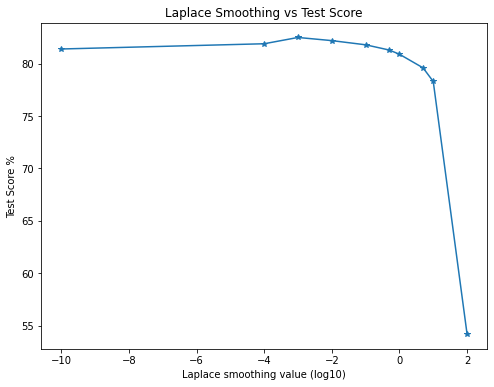

In [29]:
plt.figure(figsize=(8,6))
plt.plot(np.log10(alphas['alpha']), gridsearch.cv_results_['mean_test_score']*100, marker='*')
plt.title("Laplace Smoothing vs Test Score")
plt.ylabel("Test Score %")
plt.xlabel("Laplace smoothing value (log10)")
plt.show()

### Part 9:

Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. 

In [30]:
# Fit and predict the Gaussian Naive Bayes model before the fix using real-valued features
gnb = GaussianNB()
gnb.fit(mini_train_data, mini_train_labels)
gnb_predicts = gnb.predict(dev_data)

# Print the classification report
print("Gaussian NB pre-fix accuracy score -", classification_report(dev_labels, gnb_predicts, output_dict=True)['accuracy'])

# Review the theta, sigma, and epsilon values
print("\nMean parameters of the Gaussian distribution without smoothing:")
print(f"   Theta - {np.mean(gnb.theta_):.3f}")
print(f"   Sigma - {np.mean(gnb.sigma_):.3f}")
print(f"   Epsilon - {gnb.epsilon_:.3f}")

Gaussian NB pre-fix accuracy score - 0.593

Mean parameters of the Gaussian distribution without smoothing:
   Theta - 0.132
   Sigma - 0.053
   Epsilon - 0.000


Fix the Gaussian Naive Bayes model by increasing the var_smoothing effect.

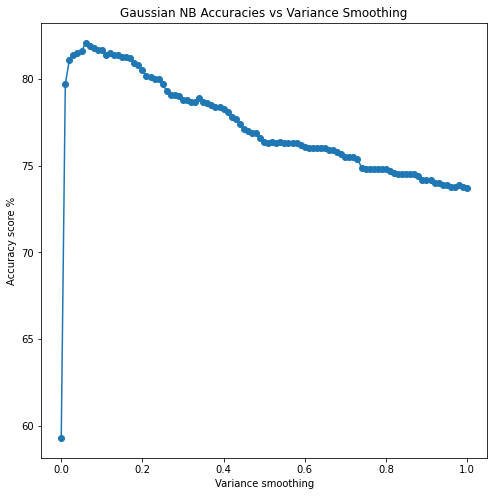

Gaussian NB after-fix accuracy score (0.060 variance smoothing) - 0.821

Mean parameters of the Gaussian distribution with smoothing:
   Theta - 0.132
   Sigma - 0.065
   Epsilon - 0.012


In [31]:
# Run a hyperparameter search function to test a range of parameters
def hyperparam_search(clf, hyperparams, train_data, train_labels, test_data, test_labels):

    '''
    Runs a hyperparameter search on a classifer given an input list of sets of hyperparameters.
    Each set of hyperparameters if passed into the classifier and the accuracy score of the 
    classifier is calculated. A list of accuracies containing each accuracy that is calculated
    is return as output.
    
    Parameters
    ----------
    clf (Classifier):
        The classifier model to be used to fit and predict the data.
    hyperparams (dict[]):
        The dictionaries of hyperparameters that should be set on the classifier per iteration 
        that the prediction accuracy is calculated.
    train_data (ndarray):
        An ndarray containing all examples and pixels within the train data set.
    train_labels (ndarray):
        An ndarray containing the list of labels for the trainig examples.
    test_data (ndarray):
        An ndarray containing all examples and pixels within the test data set.
    test_labels (ndarray):
        An ndarray containing the list of labels for the test data set.
        
    Returns
    -------
    accuracies (int[]):
        The list of prediction accuracy scores corresponding to the list of hyperparameters used. 
    '''
    
    # Initiliaze the list to store the accuracies
    accuracies = []
    
    # For each set of hyperparameters, fit the classifier and store the prediction accuracy 
    for params in hyperparams:
        model = clf()
        model.set_params(**params)
        model.fit(train_data, train_labels)
        predicts = model.predict(test_data)
        accuracies.append(classification_report(test_labels, predicts, output_dict=True)['accuracy'])
        
    return accuracies 

# Set the var_smoothing values to be tested and create a list of hyperparameters
var_vals = np.linspace(1e-09,1,101)
var_params = [{'var_smoothing':var} for var in var_vals]

# Retrieve the list accuracies scores from the hyperparameter search
smoothing_accs = hyperparam_search(GaussianNB, var_params, mini_train_data, mini_train_labels, dev_data, dev_labels)

# Plot the accuracies against the var_smoothing parameters
plt.figure(figsize=(8,8))
plt.plot(var_vals, np.multiply(smoothing_accs,100), marker='o')
plt.title("Gaussian NB Accuracies vs Variance Smoothing")
plt.xlabel("Variance smoothing")
plt.ylabel("Accuracy score %")
plt.show()

# Show model accuracy, mean, sigma, and epsilon
max_acc = max(smoothing_accs)
max_var = var_vals[smoothing_accs.index(max_acc)]
gnb1 = GaussianNB(var_smoothing=max_var).fit(mini_train_data, mini_train_labels)

print(f"Gaussian NB after-fix accuracy score ({max_var:.3f} variance smoothing) - {max_acc}")
print("\nMean parameters of the Gaussian distribution with smoothing:")
print(f"   Theta - {np.mean(gnb1.theta_):.3f}")
print(f"   Sigma - {np.mean(gnb1.sigma_):.3f}")
print(f"   Epsilon - {gnb1.epsilon_:.3f}")


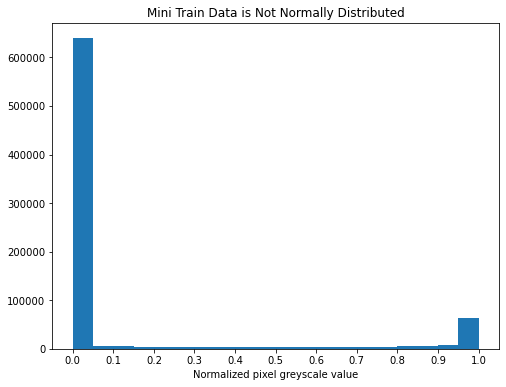

In [32]:
# Plot the histogram of the normalized greyscale values of the mini_train_data
plt.figure(figsize=(8,6))
plt.hist(mini_train_data.ravel(), bins=20)
plt.title("Mini Train Data is Not Normally Distributed")
plt.xlabel("Normalized pixel greyscale value")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()


**ANSWER:**

The Gaussian Naive Bayes algorithm assumes each feature has a underlying Gaussian, or normal, distribution. Within our digit data set, it is clear that the data are not drawn from a Gaussian distribution (as can be seen in the histogram above). From the histogram, we see that across all features, most of the values are skewed towards 0, with another smaller mode near 1. Not only is this the general trend, but many features will have much smaller variances compared to others, such as the pixels on the borders compared to those in the middle that in one digit the value could have a value close to 1, while for another digit the same pixel value could be close to 0. 

The Gaussian distribution will weight values that are farther away from the mean much smaller. Given that we can see that the original average mean for the features is ~0.13, values far away from this will not be as effective in the calculations of the frequency probabilities. In order to account for this, we can use the variance smoothing parameter to smooth the distribution and increase the weight of the values that are further away from the distribution mean. The variance smoothing parameter will effect the value of epsilon which is added to the sigma value. As a result, this will provide a more accurate prediction score given the improved weighting of values.

### Part 10:

Because Naive Bayes produces a generative model, it can be used to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

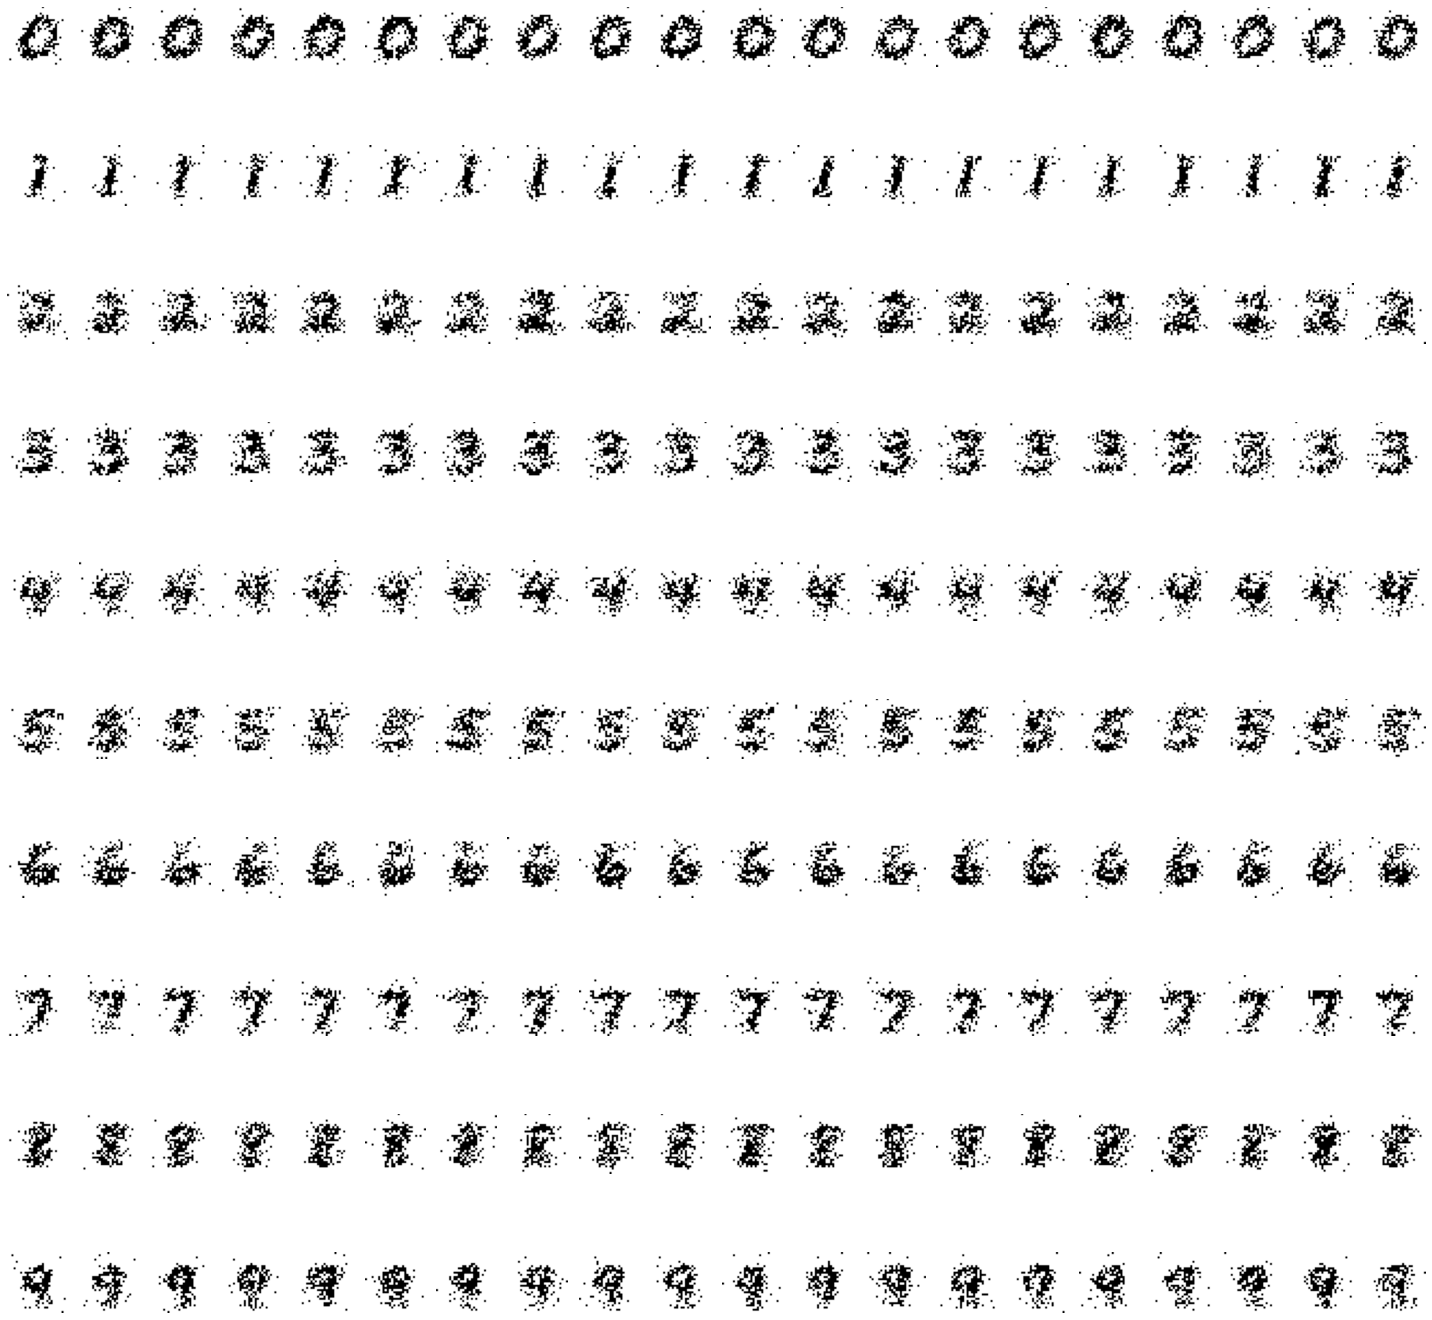

In [33]:

def generate_data(NB, num_examples=20):
    
    '''
    Generates a input number of examples of each class based off the posterior 
    probabilities of an input Naive Bayes classifier by comparing the posteriors
    to a randomly generated number to add noise.
    
    Parameters
    ----------
    NB (NaiveBayes):
        The fitted NaiveBayes model that should be used to generate examples.
    num_examples (int):
        The number of examples of each class that should be generated.
        Defaults to 20 examples.
        
    Returns
    -------
    data (ndarray):
        The randomly generated data examples from the model.
    labels (ndarray):
        The labels of the generated data examples.
    '''

    # Initialize the lists to store the generated data and corresponding labels
    data = []
    labels = []
    
    # Convert the log probabilities for each class-pixel
    P_digits = np.exp(NB.feature_log_prob_)
    
    # For every class, generate n=num_examples of data
    for label, P_digit in zip(NB.classes_, P_digits):
        for i in range(num_examples):
            
            # Generate random numbers between 0 to 1 for each pixel
            random = np.random.rand(P_digit.shape[0])
            
            # Compare the randomly generated array with the estimated probabilites and store the data
            data.append(P_digit > random)
            labels.append(label)
            
    # Convert the generated data and labels to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels


# Fit and predict the Bernoulli model
bernoulli = BernoulliNB(binarize=None)
bernoulli.fit(bin_mini_train_data, mini_train_labels)

# Generate data and labels
generated_data, generated_labels = generate_data(bernoulli, num_examples=20)

# Produce the grid of generated digits
create_grid(generated_data, generated_labels, num_examples=20)


**ANSWER:**

As can be seen from the grid above, the generated examples tend to retain the general shape and structure of each digit, but have some added random noise compared to the training examples. This is due to the fact that the randomly generated numbers that are generated to determine whether a pixel is 0 or 1 adds some noise to the pixels. 

In addition, while the training examples had a range of greyscale values, in this case we have mapped each pixel to either 0 or 1 so there are only black or white pixels.

### Part 11: 

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes and then estimate the accuracy for each bucket.  Show the accuracy for each bucket, and evaluate the overall calibration of the model.

In [34]:
def calibration(posteriors, test_labels, buckets):
    
    '''
    Calculates the calibration of a Naive Bayes model based on the correlation 
    of the posterior probabilities to the prediction accuracies. Assigns posterior 
    probabilites to bins based on the input bucket segments and calculates the 
    overall prediction accuracies of the labels within each bin. Returns the accuracy
    for each bucket.
    
    Parameters
    ----------
    posteriors (ndarray):
        The posterior probabilies of the classes for each example in the data set.
    test_labels (ndarray):
        An ndarray containing the list of labels for the test data set.
    buckets (int[]):
        The buckets that should be used to classify a prediction based on maximum posterior probability.
        
    Returns
    -------
    accuracies (int[]):
        The list of prediction accuracies per max posterior bucket. 
    '''
    
    # Initial counters for correct labels, total labels, and accuracies per bucket
    correct = [0 for i in buckets]
    total = [0 for i in buckets]
    accuracies = [0 for i in buckets]
    
    # Find the probability and index of the maximum posterior probability per example
    max_probs = np.max(posteriors, axis=1)
    max_indices = np.argmax(posteriors, axis=1)
    
    # For each example maximum probability, assign it to a bucket and compare the prediction to the label
    for prob, index, label in zip(max_probs, max_indices, test_labels):
        for i in range(len(buckets)):
        
            # If the probability is less or equal to the bucket, increment the total count for that bucket
            if prob <= buckets[i]:
                total[i] += 1
                
                # If the prediction is correct, increment the correct count for that bucket
                if index == int(label):
                    correct[i] += 1
                    
                break
    
    # For each bucket, calculate the accuracy and print the results
    for i in range(len(buckets)):        
        if total[i] > 0:
            accuracies[i] = correct[i] / total[i]
        print('Bin %d -> P(pred) between %.13f to %.13f:\ttotal = %3d,\taccuracy = %.3f' % 
          (i+1, 0 if i==0 else buckets[i-1], buckets[i], total[i], accuracies[i]))
         
    return accuracies
        
# Set up the Bernoulli NB model and retrieve the posterior probabilities
bernoulli = BernoulliNB(alpha=0.001, binarize=0)
bernoulli.fit(mini_train_data, mini_train_labels)
posteriors = bernoulli.predict_proba(dev_data)

# Create the bucket ranges
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]

# Calculate the model calibration
accuracies = calibration(posteriors, dev_labels, buckets)

Bin 1 -> P(pred) between 0.0000000000000 to 0.5000000000000:	total =   0,	accuracy = 0.000
Bin 2 -> P(pred) between 0.5000000000000 to 0.9000000000000:	total =  31,	accuracy = 0.355
Bin 3 -> P(pred) between 0.9000000000000 to 0.9990000000000:	total =  67,	accuracy = 0.433
Bin 4 -> P(pred) between 0.9990000000000 to 0.9999900000000:	total =  59,	accuracy = 0.458
Bin 5 -> P(pred) between 0.9999900000000 to 0.9999999000000:	total =  46,	accuracy = 0.652
Bin 6 -> P(pred) between 0.9999999000000 to 0.9999999990000:	total =  62,	accuracy = 0.774
Bin 7 -> P(pred) between 0.9999999990000 to 0.9999999999900:	total =  33,	accuracy = 0.788
Bin 8 -> P(pred) between 0.9999999999900 to 0.9999999999999:	total =  43,	accuracy = 0.791
Bin 9 -> P(pred) between 0.9999999999999 to 1.0000000000000:	total = 659,	accuracy = 0.938


Plot the calibration relationship between the posterior probability buckets and the overall prediction accuracy within each bucket.

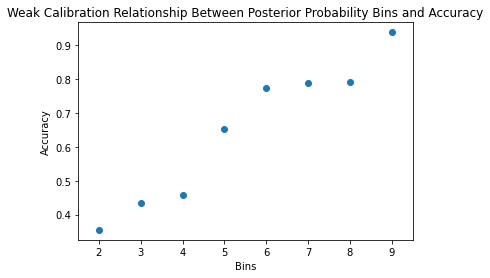

In [35]:
# Assign text labels to the bucket ranges
bins = []

for i in range(len(buckets)):
    if i==0:
        bins.append(f'0-{buckets[i]}')
    else:
        bins.append(f'{buckets[i-1]}-{buckets[i]}')

# Plot the relationship between posterior probability and accuracy
plt.scatter([i for i in range(2,10)], accuracies[1:])
plt.xlim(1.5,9.5)
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title("Weak Calibration Relationship Between Posterior Probability Bins and Accuracy")
plt.show()


**ANSWER:**

Given that the accuracy increases as the posterior probability increases, we can characterize the calibration of this Bernoulli Naive Bayes model as weakly calibrated. We can see this weak calibration relationship of posterior probability and accuracy from the plot above as well. Although not a perfect depiction of the relationship given that the bins towards the higher end represent much smaller ranges of posterior probabilities, we can still see that in general, as the probability increases so does the accuracy.

### Part 12:  Deskewing

Implement deskewing to see if it will lead to a Bernoulli Naive Bayes model with better performance. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

By deskewing the trian and test data sets, we can create greater normalization among the digits of the same class and therefore lead to more accurate predictions. When the digits are deskewed, the pixel features will become more normalized across same class digits. In order to deskew images, affine transformations are applied. 

In [56]:
def moments(digit):
    
    '''
    A function that use moment equations to find the moments of a digit image. 
    The function will calculate the moments of the center of mass (centroid) 
    and the covariance matrix of pixel intensities.
    
    Parameters
    ----------
    digit (ndarray):
        The pixel array of the digit to be used to find the moments of the image.

    Returns
    -------
    mu_vector (ndarray):
        The center of mass (centroid) moment vector of the input digit.
    covariance_maxtrix (ndarray):
        The covariance matrix moment of the input digit.
    '''
    
    # Create a mesh grid
    c0, c1 = np.mgrid[:digit.shape[0],:digit.shape[1]]
    
    # Uses moment equations to calculate weighted centroid and covariance matrix moment
    pixel_sum = np.sum(digit) 
    mu_x = np.sum(c0*digit)/pixel_sum 
    mu_y = np.sum(c1*digit)/pixel_sum 
    var_x = np.sum((c0-mu_x)**2*digit)/pixel_sum
    var_y = np.sum((c1-mu_y)**2*digit)/pixel_sum
    cov_xy = np.sum((c0-mu_x)*(c1-mu_y)*digit)/pixel_sum 
    
    # Weighted centroid 
    mu_vector = np.array([mu_x,mu_y]) 

    # Covariance matrix of pixel intensities
    covariance_matrix = np.array([[var_x,cov_xy],[cov_xy,var_y]]) 
    
    return mu_vector, covariance_matrix

def deskew(digit):

    '''
    Deskews a digit by calculating the offset and affine using the moments of the digit
    in order to attempt to recenter the digit. The offset is the vector translation of the 
    digit and the affine is the vector skew angle that should be applied to the digit.
    
    Parameters
    ----------
    digit (ndarray):
        The pixel array of the digit that will be deskewed.

    Returns
    -------
    output (ndarray):
        The new pixel array of the deskewed digit.
    '''
    
    # Calculate the center of mass and covariance matrix 
    com, cov = moments(digit)
    
    # Calculate affine
    alpha = cov[0,1]/cov[0,0]
    affine = np.array([[1,0],[alpha,1]])
    
    # Calculate offset
    ocenter = np.array(digit.shape)/2.0
    offset = com-np.dot(affine,ocenter)
    
    # Initiliaze the deskewed digit matrix
    output = np.zeros(digit.shape)
    
    # For every non-zero pixel, use affine transformation to calculate the new coordinates of the pixel
    for row in range(digit.shape[0]):
        for col in range(digit.shape[1]):
            if digit[row][col] > 0:
                new_coords = np.dot(np.linalg.inv(affine), ([[row], [col]]) - offset.reshape(-1,1)).astype(int)
                if new_coords[0][0] > 27 or new_coords[1][0] > 27:
                    continue
                output[new_coords[0][0]][new_coords[1][0]] = digit[row][col]
                
    return output

Deskwed the train and test data digits and then use a binarization threshold of 0 to fit and predict data using a Bernoulli Naive Bayes model.

In [37]:
# Deskew both dev and mini_train data                
deskewed_dev_data = []
deskewed_mini_train_data = []

for data in dev_data:
    deskewed_dev_data.append(deskew(data.reshape(28,28)).ravel())
    
for data in mini_train_data:
    deskewed_mini_train_data.append(deskew(data.reshape(28,28)).ravel())

# Fit and predict the Bernoulli model
bern = BernoulliNB(binarize=0)
bern.fit(mini_train_data, mini_train_labels)
bern_predicts = bern.predict(dev_data)

# Fit and predict the Bernoulli model with deskewed data
bern_ds = BernoulliNB(binarize=0)
bern_ds.fit(deskewed_mini_train_data, mini_train_labels)
bern_ds_predicts = bern_ds.predict(deskewed_dev_data)

With train and test data digits deskewed, the modeling accuracy increases from 80.9% up to 87.3%.

In [38]:
# Print the accuracy scores for each model
print("Bernoulli NB accuracy score -", classification_report(dev_labels, bern_predicts, output_dict=True)['accuracy'])
print("Deskwed Bernoulli NB accuracy score -", classification_report(dev_labels, bern_ds_predicts, output_dict=True)['accuracy'])

Bernoulli NB accuracy score - 0.809
Deskwed Bernoulli NB accuracy score - 0.873


The deskewed digits can be visualized to show how the digits tend to become normalized across each class (center aligned and rotated along the center). The axes below are included to show the alignment of the digits with" the center. 

The first grid contains the original digits, while the second grid contains the deskewed digits (both grids contain the same examples).

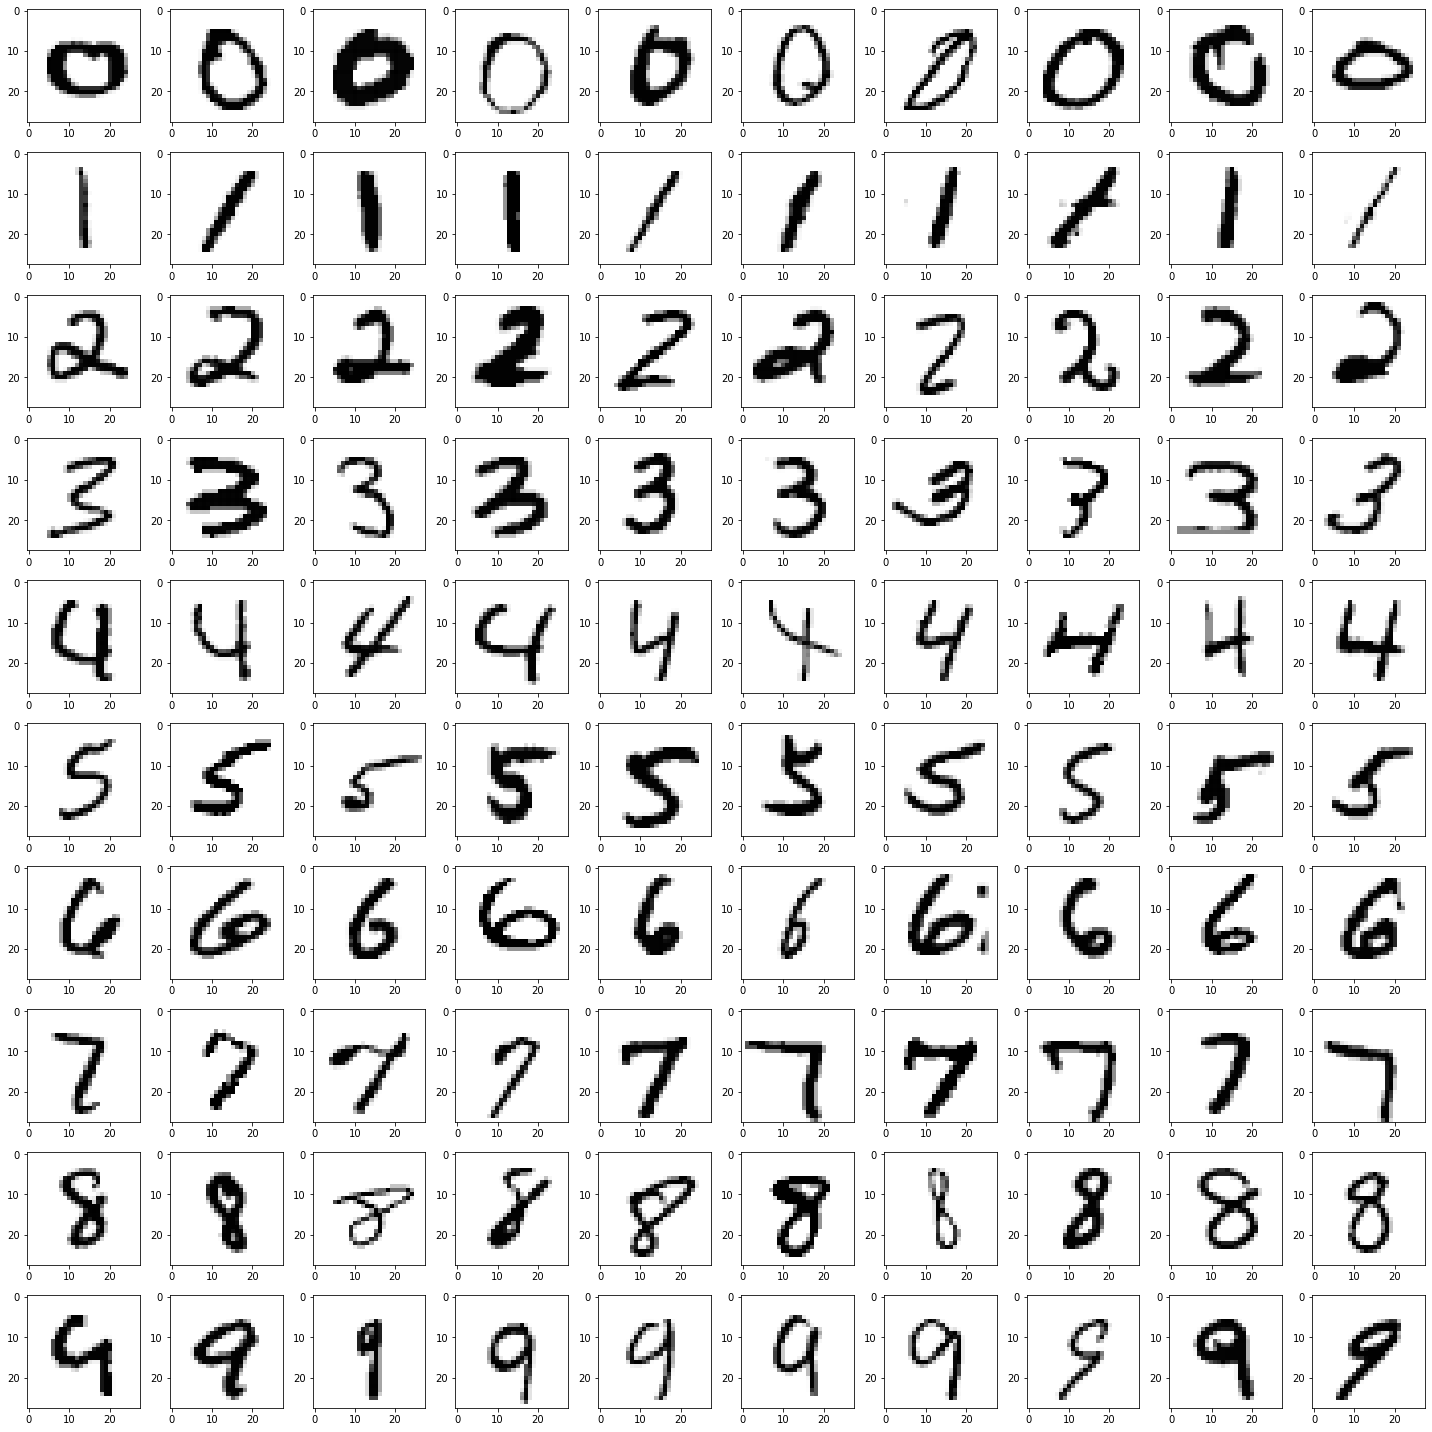

In [39]:
# Original digits
create_grid(dev_data, dev_labels, axes='on')

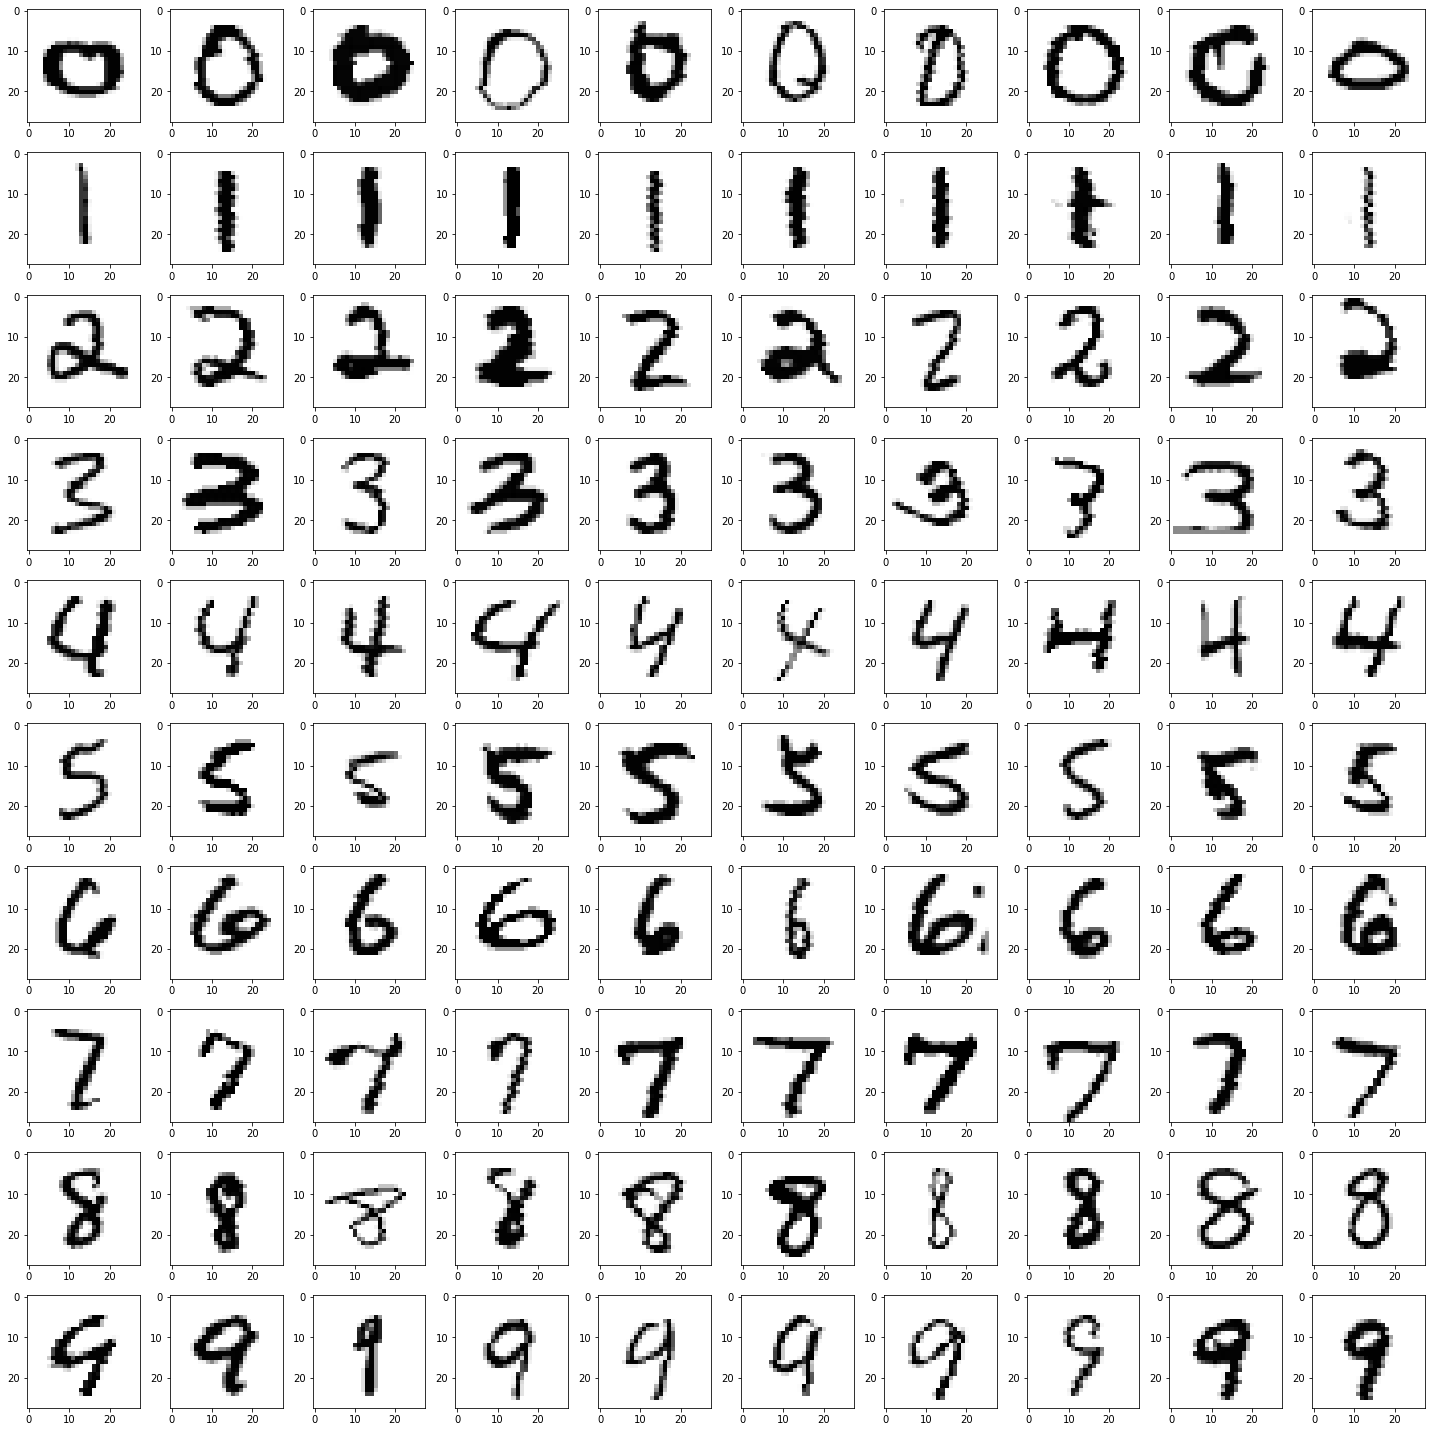

In [40]:
# Deskewed digits
create_grid(deskewed_dev_data, dev_labels, num_examples=10, axes='on')

### Best performing model

The best performing model is realized when the following applications are used:

- 5-Nearest Neighbor Model
- Deskewed data
- Guassian blurring of data with radis = 1, sigma = 1.2


In [ ]:
# Deskew both test and train data                
deskewed_test_data = []
deskewed_train_data = []

print("Deskewing test data...")
for data in test_data:
    deskewed_test_data.append(deskew(data.reshape(28,28)).ravel())
    
print("Deskewing train data...")
for data in train_data:
    deskewed_train_data.append(deskew(data.reshape(28,28)).ravel())
    
# Convert the deskewed data to ndarrays
deskewed_test_data = np.array(deskewed_test_data)
deskewed_train_data = np.array(deskewed_train_data)
    
# Set the hyperparameters (blur radius, sigma weight, and k value for nearest neighbors)
radius = 1
sigma = 1.2
k = 5

# Create the weighted matrix
w_matrix = weighted_matrix(sigma, blur_radius=radius)

# Blur the train and dev datasets
print("Blurring train data...")
train_blur = blur_data(deskewed_train_data, w_matrix, blur_radius=radius)

print("Blurring test data...")
test_blur = blur_data(deskewed_test_data, w_matrix, blur_radius=radius)

# Make predictions on the test data
print("Making predictions...")
print()
predicts = KNN_model_predict(k, train_blur, train_labels, test_blur)

print(classification_report(test_labels, predicts))
print("Precise accuracy:", classification_report(test_labels, predicts, output_dict=True)['accuracy'])

Deskewing test data...
Deskewing train data...
